In [57]:
import tensorflow as tf

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU(s) available:", gpus)
else:
    print("No GPU found. Running on CPU.")

TensorFlow version: 2.10.1
GPU(s) available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import LearningRateScheduler

#### Checking

In [59]:
# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU(s) available:", gpus)
else:
    print("No GPU found. Running on CPU.")


TensorFlow version: 2.10.1
GPU(s) available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Inserting csv

In [60]:
df = pd.read_csv("csv/PROGNOSA 2021-2024.csv")

In [61]:
bulan_mapping = {
    "januari": "01", "februari": "02", "maret": "03", "april": "04",
    "mei": "05", "juni": "06", "juli": "07", "agustus": "08",
    "september": "09", "oktober": "10", "november": "11", "desember": "12"
}


In [62]:
df["bulan_num"] = df["bulan"].str.lower().map(bulan_mapping)
df["tanggal"] = pd.to_datetime(df["tahun"].astype(str) + "-" + df["bulan_num"] + "-01")
df = df.sort_values("tanggal")

In [63]:
df_pivot = df.pivot_table(index=["tanggal", "tanaman", "daerah"], 
                          columns="tipe", values="total").reset_index()

In [64]:
tanaman_pilihan = "padi"
df_filtered = df_pivot[df_pivot["tanaman"].str.lower() == tanaman_pilihan.lower()].copy()

In [65]:
features = ["luastanam", "luaspanen", "produksi"]
df_filtered = df_filtered[["tanggal"] + features].dropna()

In [66]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_filtered[features])

In [67]:
# Fungsi untuk membuat data sequence (windowing)
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length])
    return np.array(sequences), np.array(targets)

# Set panjang sequence (misalnya 12 bulan ke belakang)
seq_length = 12
X, y = create_sequences(df_scaled, seq_length)

# Split data (80% train, 20% test)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

#### Modeling

In [68]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(3)#output 3 karena ada 3 features
])

In [69]:
def lr_warmup(epoch, lr):
    if epoch < 10:  # Warmup selama 10 epoch pertama
        return lr * (epoch + 1) / 10
    return lr

lr_scheduler = LearningRateScheduler(lr_warmup)

initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=10000, decay_rate=0.96, staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [70]:
model.compile(optimizer=optimizer, loss="mse")

history = model.fit(X_train, y_train, epochs=1000, batch_size=2, validation_data=(X_test, y_test), verbose=1)

predictions = model.predict(X_test)

predictions_denorm = scaler.inverse_transform(predictions)
y_test_denorm = scaler.inverse_transform(y_test)

Epoch 1/1000
590/590 [==============================] - 9s 11ms/step - loss: 0.0220 - val_loss: 0.0197
Epoch 2/1000
590/590 [==============================] - 9s 15ms/step - loss: 0.0214 - val_loss: 0.0201
Epoch 3/1000
590/590 [==============================] - 8s 13ms/step - loss: 0.0203 - val_loss: 0.0195
Epoch 4/1000
590/590 [==============================] - 9s 15ms/step - loss: 0.0206 - val_loss: 0.0196
Epoch 5/1000
590/590 [==============================] - 9s 15ms/step - loss: 0.0204 - val_loss: 0.0195
Epoch 6/1000
590/590 [==============================] - 9s 16ms/step - loss: 0.0203 - val_loss: 0.0194
Epoch 7/1000
590/590 [==============================] - 8s 13ms/step - loss: 0.0205 - val_loss: 0.0195
Epoch 8/1000
590/590 [==============================] - 8s 13ms/step - loss: 0.0204 - val_loss: 0.0193
Epoch 9/1000
590/590 [==============================] - 8s 13ms/step - loss: 0.0203 - val_loss: 0.0195
Epoch 10/1000
590/590 [==============================] - 8s 13ms/step - l

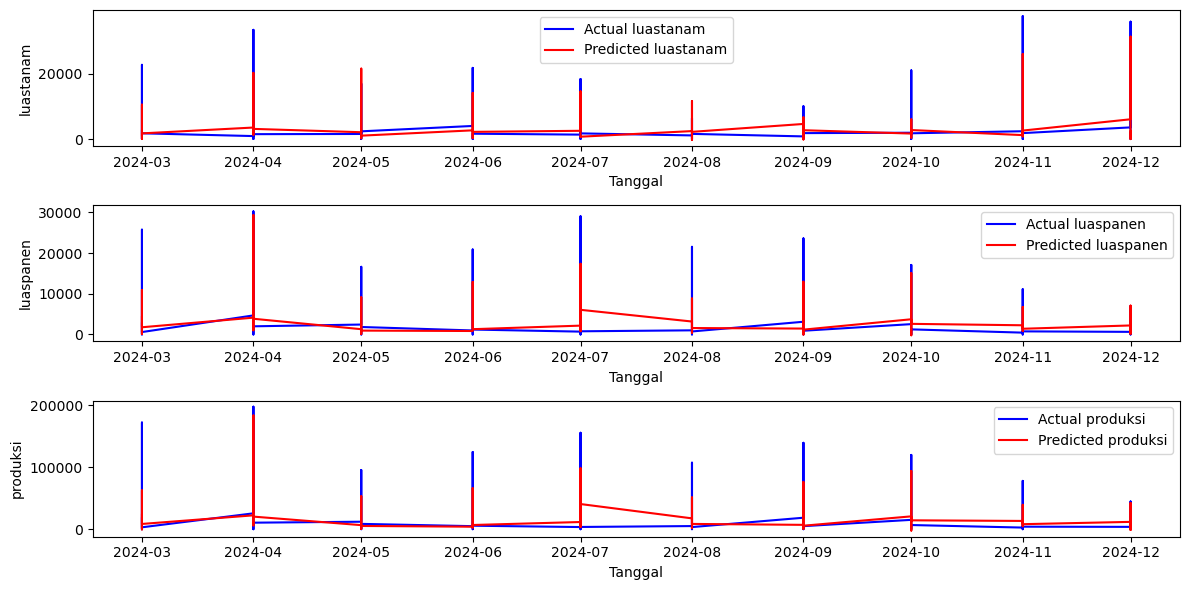

In [71]:
plt.figure(figsize=(12, 6))
for i, feature in enumerate(features):
    plt.subplot(3, 1, i+1)
    plt.plot(df_filtered["tanggal"].iloc[split+seq_length:], y_test_denorm[:, i], label="Actual " + feature, color="blue")
    plt.plot(df_filtered["tanggal"].iloc[split+seq_length:], predictions_denorm[:, i], label="Predicted " + feature, color="red")
    plt.xlabel("Tanggal")
    plt.ylabel(feature)
    plt.legend()
plt.tight_layout()
plt.show()